In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC

from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, ZeroPadding2D, GlobalAveragePooling2D, Activation, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

2024-11-20 16:34:16.783702: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# !mkdir -p ~/.kaggle
# !cp kaggle-2.json ~/.kaggle/

In [3]:
# !kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

In [4]:
# import zipfile
# zip = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
# zip.extractall("/content")
# zip.close()

In [5]:
train_dir = '/scratch/pkarn/kaggledata/Training'
test_dir = '/scratch/pkarn/kaggledata/Testing'

In [6]:
import tensorflow as tf
train_ds_resnet = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

validation_ds_resnet = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                   labels = 'inferred',
                                                   label_mode = 'int',
                                                   batch_size = 32,
                                                   image_size = (224,224))

Found 5712 files belonging to 4 classes.


2024-11-20 16:34:18.581331: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-20 16:34:18.582356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-20 16:34:18.695124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: NVIDIA A100-SXM4-80GB MIG 2g.20gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 28 deviceMemorySize: 19.50GiB deviceMemoryBandwidth: 474.75GiB/s
2024-11-20 16:34:18.695174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 16:34:18.697370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-20 16:34:18.697419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcub

Found 1311 files belonging to 4 classes.


In [7]:
def preprocess_resnet(image, label):   # To preprocess the pixel values

    image = preprocess_input(image)

    return image, label

train_ds_resnet.map(preprocess_resnet)
validation_ds_resnet.map(preprocess_resnet)

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [8]:
conv_base_resnet = ResNet50(include_top=False,
                    weights = 'imagenet',
                    input_shape=(224,224,3))

conv_base_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
for layer in conv_base_resnet.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [10]:
# Unfreezing the last 5th stage layers to make those weights trainable

conv_base_resnet.trainable = False
set_trainable = False

for layer in conv_base_resnet.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True

    if set_trainable:
        layer.trainable = True

    else:
        layer.trainable = False

for layer in conv_base_resnet.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [11]:
import tensorflow as tf

from tensorflow.keras.models import Model

# Creating a new model and adding fully connected layers
x = conv_base_resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax', name='fc1000')(x)

model = Model(inputs=conv_base_resnet.input, outputs=x)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

local_save_path = '/home/pkarn/CSE_575_Project/BEST_resnet50_pretrained2.keras'

os.makedirs(os.path.dirname(local_save_path), exist_ok=True)

checkpoint = ModelCheckpoint(filepath=local_save_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=False,
                              verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          patience=6,
                                          verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               verbose=1,
                               patience=10)

callbacks = [checkpoint, reduce_learning_rate, early_stopping]

In [14]:
from tensorflow.keras.optimizers import Adam, RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(train_ds_resnet, epochs=10,
                    batch_size=32,
                    validation_data = validation_ds_resnet,
                    verbose=1,
                    callbacks = callbacks)

Epoch 1/10


2024-11-20 16:34:24.599438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-20 16:34:24.623542: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2644870000 Hz
2024-11-20 16:34:25.038214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-20 16:34:35.096339: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-11-20 16:45:36.092455: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-11-20 16:45:36.301326: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


179/179 [==============================] - ETA: 0s - loss: 1.4610 - accuracy: 0.2664

2024-11-20 16:51:13.065736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 180 of 256
2024-11-20 16:51:15.723294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


179/179 [==============================] - 1091s 2s/step - loss: 1.4607 - accuracy: 0.2665 - val_loss: 1.3857 - val_accuracy: 0.3089

Epoch 00001: val_loss improved from inf to 1.38570, saving model to /home/pkarn/CSE_575_Project/BEST_resnet50_pretrained2.keras
Epoch 2/10


2024-11-20 16:52:44.793401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 236 of 256
2024-11-20 16:52:45.336004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


179/179 [==============================] - 66s 304ms/step - loss: 1.3860 - accuracy: 0.2761 - val_loss: 1.3854 - val_accuracy: 0.3089

Epoch 00002: val_loss improved from 1.38570 to 1.38538, saving model to /home/pkarn/CSE_575_Project/BEST_resnet50_pretrained2.keras
Epoch 3/10
179/179 [==============================] - 25s 139ms/step - loss: 1.3857 - accuracy: 0.2789 - val_loss: 1.3850 - val_accuracy: 0.3089

Epoch 00003: val_loss improved from 1.38538 to 1.38502, saving model to /home/pkarn/CSE_575_Project/BEST_resnet50_pretrained2.keras
Epoch 4/10
179/179 [==============================] - 28s 153ms/step - loss: 1.3855 - accuracy: 0.2793 - val_loss: 1.3846 - val_accuracy: 0.3089

Epoch 00004: val_loss improved from 1.38502 to 1.38460, saving model to /home/pkarn/CSE_575_Project/BEST_resnet50_pretrained2.keras
Epoch 5/10
179/179 [==============================] - 26s 145ms/step - loss: 1.3852 - accuracy: 0.2775 - val_loss: 1.3843 - val_accuracy: 0.3089

Epoch 00005: val_loss improved 

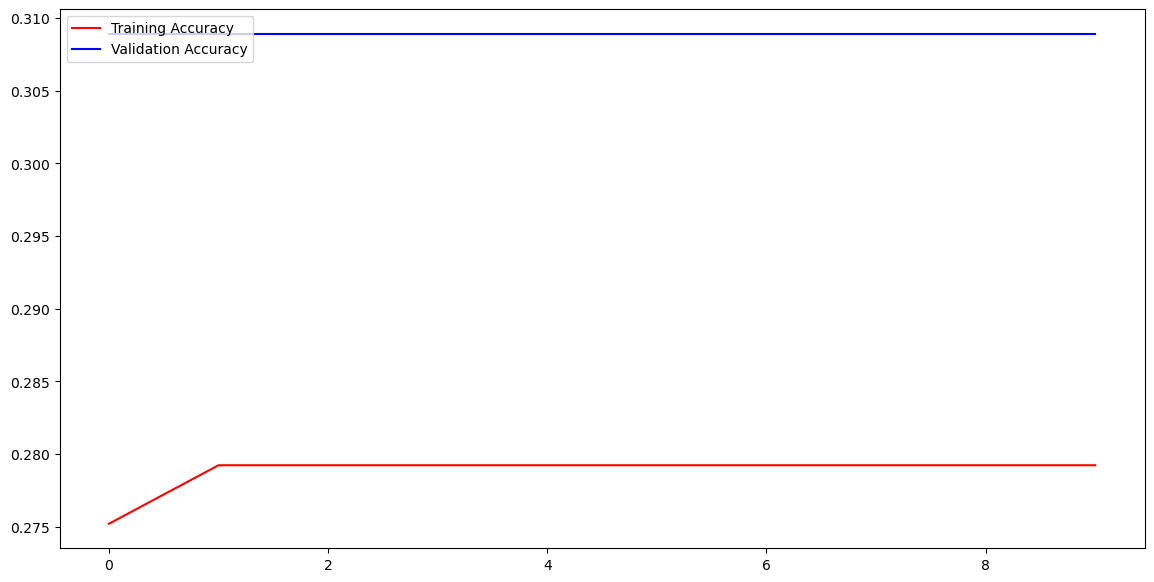

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

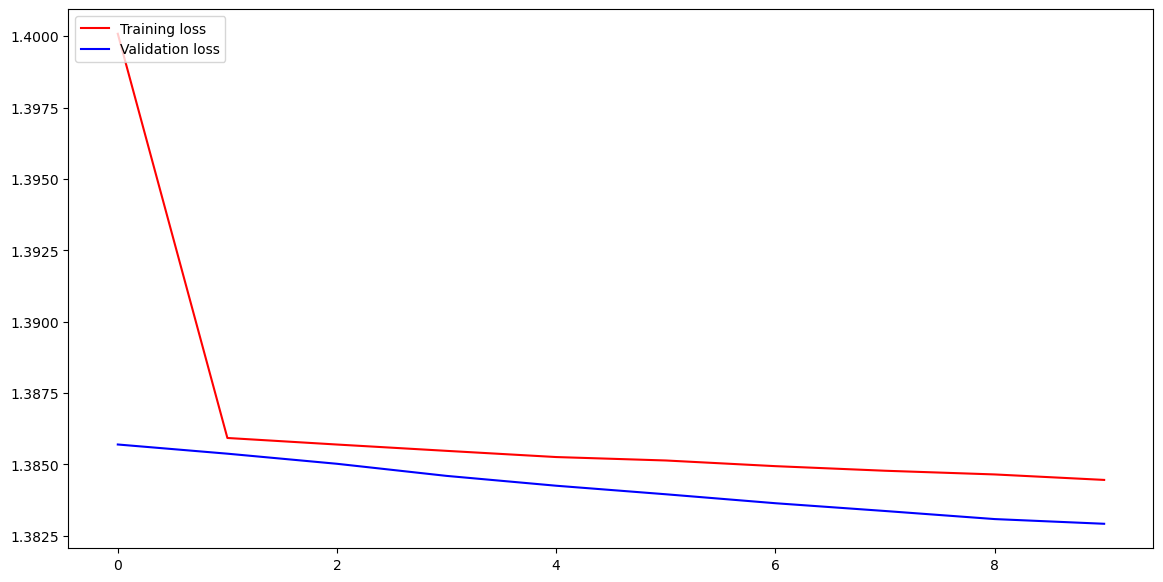

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [19]:
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/content/BEST_resnet50_pretrained2.keras')

predict_list = []
true_labels = []

for batch in validation_ds_resnet:

    images, labels = batch
    true_labels.extend(labels.numpy())

    for img in images:
        img_array = np.array(img)
        img_array = img_array.reshape(1, 224, 224, 3)

        pred = model.predict(img_array)

        indices = pred.argmax()

        predict_list.append(indices)

OSError: SavedModel file does not exist at: /content/BEST_resnet50_pretrained2.keras/{saved_model.pbtxt|saved_model.pb}

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
cm = confusion_matrix(true_labels, predict_list)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predict_list))